#QSB Project

In [1]:
%matplotlib inline

# import csv
import matplotlib.pyplot as plt 
import numpy as np
from scipy.optimize import curve_fit
from pysb import *
from pysb.macros import *
import pylab as pl
from pysb.integrate import odesolve, Solver
import pandas as pd
from IPython.display import HTML
from scipy.stats import stats
from scipy.spatial.distance import pdist
from copy import deepcopy

##Sensitivity analysis
In this section, the importance of each parameter will be assessed.  
In this analysis, the output (on idividual molecules) of the original model will be compared with the output of a model where one parameter has been changed

###Distance and statistics
Since the parameter space is the same in both the experiment (modified model) and the control (model fitted from experiments), an euclidean distance was chosen as a measure of distance.  
It has to be noted, that the euclidean distance is susceptible to complementary fluctuations, as seen below

In [2]:
pdist([[3,2,3],[1,2,3]])

array([ 2.])

In [3]:
pdist([[3,2,3],[3,4,3]])

array([ 2.])

As a significance measure, the Mann-Whitney U test was chosen because it can work with zero-values in the null distribution, and behaves better with non-normal distributions

In [4]:
HTML("<iframe src='http://en.wikipedia.org/wiki/Mann-Whitney_U_test' width='800' height='600' style='border:0'></iframe>")

Import model

In [5]:
import qsb_model as m

In [6]:
def DLK(u,v,epsilon,bg):
    '''
    Calculate Kullback-Leibler divergence
    u,v: numpy arrays
    e: epsilon -> pseudocounts to add
    bg: background weight. Under a uniform distribution, bg is 1/(4^k)
    '''
    ps_count = epsilon * bg
    # Get proportions and add pseudocount
    u_prop = 1 - (u + ps_count) / sum(u)
    v_prop = 1 - (v + ps_count) / sum(v)
    dlk = sum(u_prop * np.log2(u_prop/v_prop))
    return dlk

def JSD(u,v,epsilon,bg):
    '''
    Calculate the Jensen-Shannon distance
    u,v: numpy arrays
    e and bg are arguments for DLK
    e: epsilon -> pseudocounts to add
    bg: background weight. Under a uniform distribution, bg is 1/(4^k)
    '''
    m = (u + v) / 2
    # Calculate Jensen-Shannon divergence
    js_div = (DLK(u,m,epsilon,bg) + DLK(v,m,epsilon,bg)) / 2
    #Calculate Jensen-Shannon distance
    jsdist = np.sqrt(js_div)
    return jsdist

In [20]:
reload(m)
# Extract initial conditions (We are not going to change these
initial_conditions = [x[1] for x in m.model.initial_conditions]
# Filter out initial concentrations from the parameters that we are going to use
params_to_change = [param for param in m.model.parameters if not param in initial_conditions]

def messed_up_param(model,param,out_var,samples):
    '''
    Measure the extent at which modifying a parameter of a model
    will change the production of a molecule specified by it
    input: 
    model: pysb model
    param: parameter to be evaluated
    out_var: output molecule to me measured
    order_magnitude: The parameter will be modified X orders of 
    magnitude below and above its experimentally fitted value
    samples: samples to be generated
    '''
    # set integration interval
    t = np.linspace(0,200000)
    # Store original parameter value
#     print(param.value)
    old_param_value = np.real(param.value)
    # The parameter will be modified _samples_ times
    # _order_magnitude_ orders of magnitude
    
    # Solve the ODE system for the original model
    yout_old = odesolve(model.model, t)
    # Extract output variable to be analyzed
    analyte = np.array([x for x in yout_old[out_var]])
#     print("Parameter {} will be scanned for deviations on {} production".format(param.args[0],out_var))
    sample_output = {}
#     fig = plt.figure(figsize=(20,20))
#     axes = [fig.add_subplot(len(value_list)/3,len(value_list)/2,x) for x in range(1,len(value_list)+1)]
    news = []
#     print(value_list)
    value_list = np.arange(old_param_value/samples,old_param_value*samples,old_param_value)
#     value_list = np.arange(0,1,1e-5)
    for value in value_list:
        # Set the parameter to the new value
        param.value = value
        # Solve the ODE
        Solver(model.model,t)
        yout = odesolve(model.model,t)
        # Extract the values of the analyte that is being compared
        new_analyte = yout[out_var]
        news.append(new_analyte)
#         print(param.value)
        # Calculate a U-test to see if the two distributions
        # are significantly different
        t_test,pval = stats.ttest_ind(new_analyte,analyte)
        
        # Measure the euclidean distance between the sample and the original model
        euclidean = pdist([new_analyte,analyte])
        # Measure the JSD
#         jsd = DLK(analyte,new_analyte,1,1/analyte[-1])
        # Store result in dictionary
        sample_output[value] = [euclidean,pval]
#         ax.plot(t,new_analyte)
        # Organize result as a table
        sample_output_table = pd.DataFrame.from_dict(sample_output,orient='index')
        sample_output_table.columns=['euclidean','T_test_Pval']
        sample_output_table.index.name = param.args[0]
        sample_output_table.reset_index(inplace=True)
        sample_output_table.sort(param.args[0],inplace=True)
        sample_output_table.set_index(param.args[0],inplace=True)
#     fig.tight_layout()
    return sample_output_table,news,value_list,analyte

qsb_model.py:60: ModelExistsWarning: Redefining model! (You can probably ignore this if you are running code interactively)
  Model()


In [21]:
perturbations = {}
for output in ['mBid','aSmac','cPARP']:
    print(output)
    perturbations[output] = {param.args[0]: messed_up_param(m,param,output,100) for param in params_to_change}

mBid
aSmac
cPARP


0
0
0


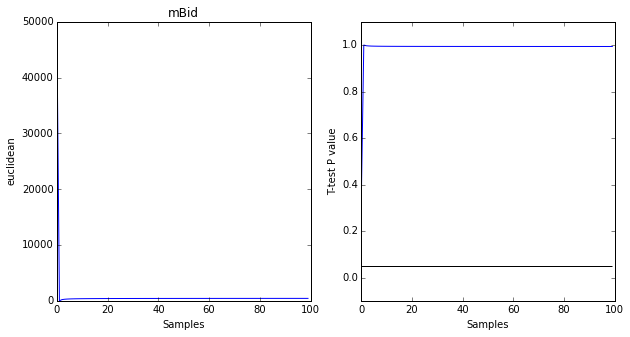

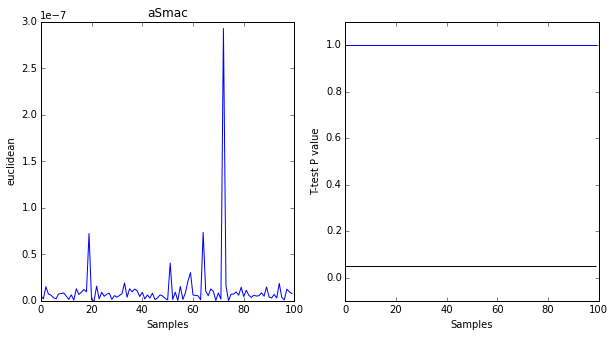

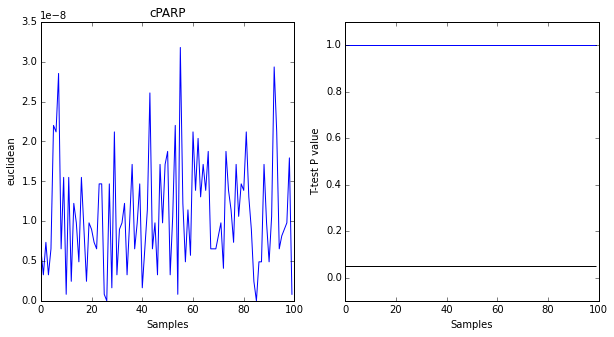

In [25]:
for i in ['mBid','aSmac','cPARP']:
    messed_up = perturbations[i]['bind_C8_Bidn_to_C8Bidn_kf'][0]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)
    ax1.plot(messed_up['euclidean'].values)
    ax1.set_xlabel("Samples")
    ax1.set_ylabel("euclidean")
    ax1.set_title(i)

    ax2 = fig.add_subplot(122)
    ax2.plot(messed_up['T_test_Pval'].values)
    ax2.set_xlabel("Samples")
    ax2.set_ylabel("T-test P value")
    ax2.set_ylim(-0.1,1.1)
    print(len(messed_up[messed_up['T_test_Pval'] < 0.00005]))
    ax2.hlines(0.05,0,100)


In [ ]:
analyte = perturbations['mBid']['bind_C8_Bidn_to_C8Bidn_kf'][1][0]

In [ ]:
new_analyte = perturbations['mBid']['bind_C8_Bidn_to_C8Bidn_kf'][3]

In [ ]:
JSD(new_analyte,analyte,1,1/analyte[-1])

In [ ]:
JSD(np.array([1,2,3]),np.array([1,2,3]),1,1/analyte[-1])

In [ ]:
new_array = 1-perturbations['mBid']['bind_C8_Bidn_to_C8Bidn_kf'][1][1] / maximum
# new_array += max(perturbations['mBid']['bind_C8_Bidn_to_C8Bidn_kf'][1][1])
# new_array = np.insert(new_array,0,0)

In [ ]:
maximum

In [ ]:
meh = np.round(1-new_array)
plt.plot(range(len(new_array)),new_array)

In [ ]:
meh.sum()

In [ ]:
new_array